Training model...
Epoch 1/50, Train Loss: 2.1843, Train Acc: 15.77%, Val Loss: 2.2593, Val Acc: 19.50%
Epoch 2/50, Train Loss: 1.9885, Train Acc: 23.90%, Val Loss: 2.2226, Val Acc: 21.50%
Epoch 3/50, Train Loss: 1.8347, Train Acc: 28.04%, Val Loss: 1.8140, Val Acc: 36.50%
Epoch 4/50, Train Loss: 1.7023, Train Acc: 38.42%, Val Loss: 1.5009, Val Acc: 42.50%
Epoch 5/50, Train Loss: 1.6117, Train Acc: 35.67%, Val Loss: 2.0154, Val Acc: 35.00%
Epoch 6/50, Train Loss: 1.6381, Train Acc: 38.05%, Val Loss: 1.6801, Val Acc: 40.50%
Epoch 7/50, Train Loss: 1.5236, Train Acc: 40.68%, Val Loss: 1.4115, Val Acc: 53.00%
Epoch 8/50, Train Loss: 1.4320, Train Acc: 45.31%, Val Loss: 1.6022, Val Acc: 41.00%
Epoch 9/50, Train Loss: 1.4348, Train Acc: 46.68%, Val Loss: 1.3593, Val Acc: 53.50%
Epoch 10/50, Train Loss: 1.4374, Train Acc: 48.44%, Val Loss: 1.4553, Val Acc: 53.50%
Epoch 11/50, Train Loss: 1.4215, Train Acc: 46.56%, Val Loss: 1.2484, Val Acc: 55.00%
Epoch 12/50, Train Loss: 1.3692, Train Acc: 5

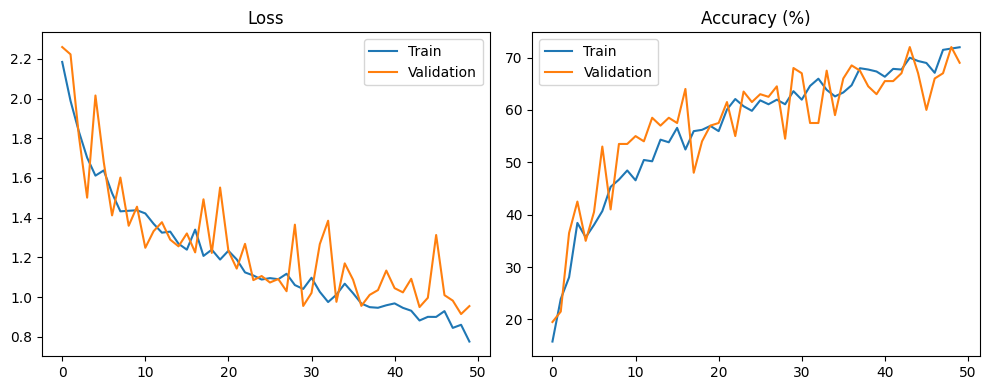

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define genres and device
GENRES = ['rock', 'reggae', 'pop', 'metal', 'jazz', 'hiphop', 'disco', 'country', 'classical', 'blues']
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simple dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.adaptive_pool(x)
        x = self.fc(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Load spectrograms and create train/val datasets
def prepare_data(data_dir, batch_size=32):
    all_files = []
    all_labels = []
    
    # Collect all spectrogram files
    for i, genre in enumerate(GENRES):
        genre_path = os.path.join(data_dir, genre)
        if os.path.exists(genre_path):
            files = [os.path.join(genre_path, f) 
                    for f in os.listdir(genre_path) 
                    if f.endswith(('.png', '.jpg', '.jpeg'))]
            all_files.extend(files)
            all_labels.extend([i] * len(files))
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        all_files, all_labels, test_size=0.2, random_state=42
    )
    
    # Define transformations
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),      # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats for better transfer learning
])
    
    # Create datasets
    train_dataset = SpectrogramDataset(X_train, y_train, transform)
    val_dataset = SpectrogramDataset(X_val, y_val, transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_loader, val_loader

# Training function
def train(model, train_loader, val_loader, epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
    # Save model
    torch.save(model.state_dict(), 'spectrogram_model.pth')
    return history

# Function to visualize results
def plot_results(history):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()

# Function to classify a new spectrogram
def classify(model, image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        
    return GENRES[predicted.item()]

# Main function
def main():
    # Set data directory
    data_dir = '/kaggle/input/spectograms/for_cnn'  # Update this to your actual path
    
    # Prepare data
    train_loader, val_loader = prepare_data(data_dir, batch_size=32)
    
    # Initialize and train model
    model = SimpleCNN().to(DEVICE)
    print("Training model...")
    history = train(model, train_loader, val_loader, epochs=50)
    
    # Plot results
    plot_results(history)
    


if __name__ == "__main__":
    main()

In [6]:
# Load the trained model
model = SimpleCNN(num_classes=10).to(DEVICE)
model.load_state_dict(torch.load('spectrogram_model.pth', map_location=DEVICE))
model.eval()

# Function to predict genre from an image path
def predict_genre(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        genre = GENRES[predicted.item()]
    
    print(f"Predicted Genre: {genre}")
    return genre

# Example usage
sample_image_path = '/kaggle/input/spectograms/for_cnn/blues/blues.00009.png'  # <<--- Replace this with your image path
predict_genre(sample_image_path)

Predicted Genre: blues


/tmp/ipykernel_31/3533704495.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('spectrogram_model.pth', map_location=DEVICE))


'blues'

/tmp/ipykernel_31/2489221383.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load('spectrogram_model.pth', map_location=DEVICE))


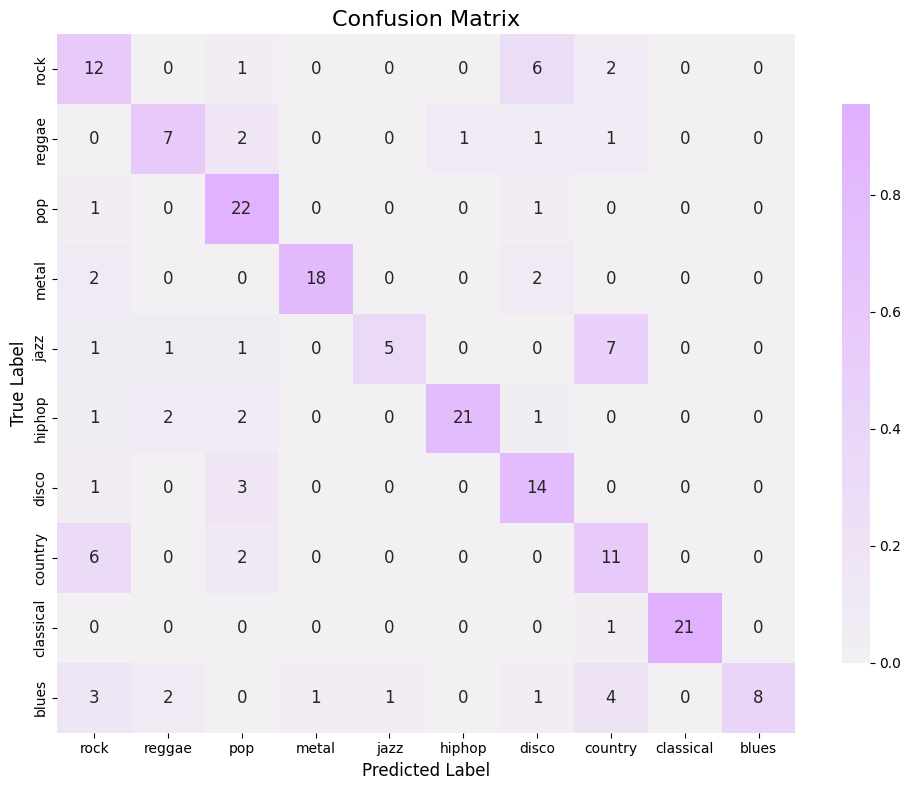

In [8]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, data_loader, class_names, device):
    """
    Plot a confusion matrix for the given model and dataset.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    
    # Create a custom orange color map
    orange_cmap = sns.light_palette("#E0B0FF", as_cmap=True)
    
    sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap=orange_cmap,
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}, cbar_kws={"shrink": 0.8})
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # After training
    trained_model = SimpleCNN(num_classes=10).to(DEVICE)
    trained_model.load_state_dict(torch.load('spectrogram_model.pth', map_location=DEVICE))
    trained_model.eval()
    
    # Create val_loader again if needed (or reuse)
    _, val_loader = prepare_data('/kaggle/input/spectograms/for_cnn', batch_size=32)
    
    plot_confusion_matrix(trained_model, val_loader, GENRES, DEVICE)

/tmp/ipykernel_31/1382257383.py:341: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/resnet/pytorch/default/1/genre_classifier_

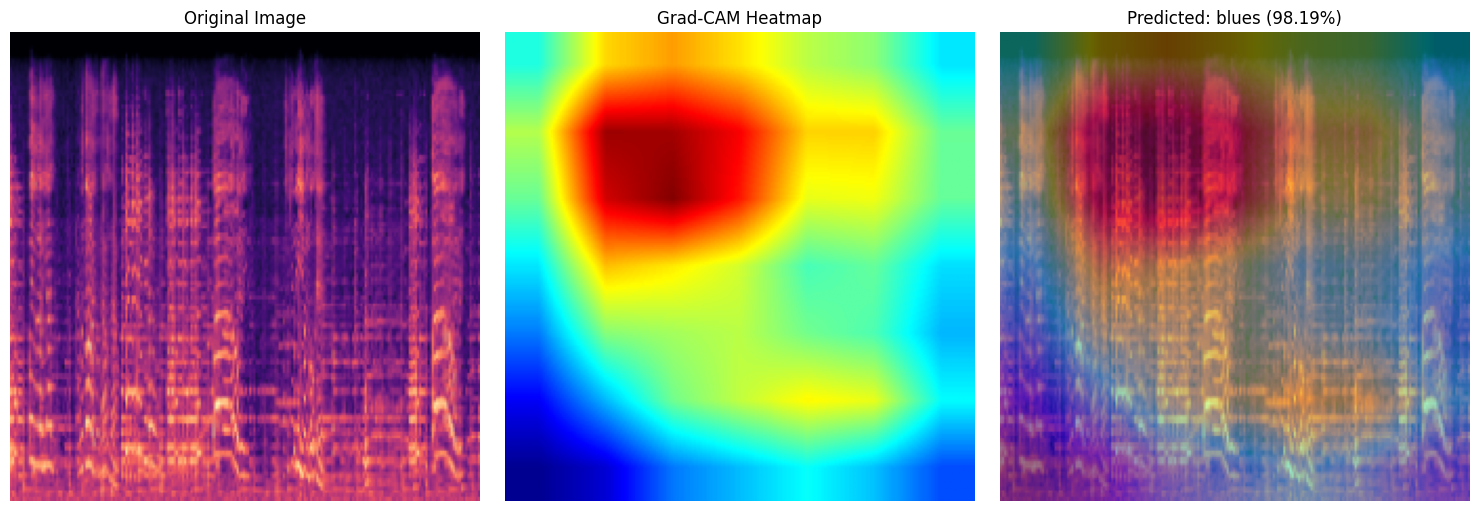

<Figure size 640x480 with 0 Axes>

'"\n# For multiple images from your dataset\nfig = visualize_model_attention(\n    model_path=MODEL_PATH,                        # Path to saved model\n    data_dir=DATA_DIR,                            # Your dataset directory\n    class_names=class_names,                      # Your class names list\n    device=DEVICE,                                # \'cuda\' or \'cpu\'\n    num_images=9                                  # Number of images to visualize\n)\nplt.savefig(\'gradcam_attention.png\', dpi=300, bbox_inches=\'tight\')\nplt.show()\n'

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import os
from torchvision.utils import make_grid
import cv2

class GradCAM:
    """
    Grad-CAM implementation for visualization of model attention
    """
    def __init__(self, model, target_layer):
        """
        Args:
            model: Trained PyTorch model
            target_layer: Layer to extract gradients from (e.g., model.layer4)
        """
        self.model = model
        self.target_layer = target_layer
        self.hooks = []
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.register_hooks()
        
        # Set model to evaluation mode
        self.model.eval()
    
    def register_hooks(self):
        """Register forward and backward hooks to the target layer"""
        
        # Forward hook
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        # Backward hook
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        # Register the hooks
        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_full_backward_hook(backward_hook)
        
        # Save handles for cleanup
        self.hooks = [forward_handle, backward_handle]
        
    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
    
    def generate_cam(self, input_tensor, target_class=None):
        """
        Generate Grad-CAM for the input image
        
        Args:
            input_tensor: Preprocessed image tensor [1, C, H, W]
            target_class: Target class index. If None, uses the predicted class
            
        Returns:
            cam: Normalized CAM visualization
            pred_class: Predicted class index
            pred_prob: Prediction probability
        """
        # Forward pass
        output = self.model(input_tensor)
        
        # Get predicted class if target_class not specified
        if target_class is None:
            pred_probs = F.softmax(output, dim=1)
            pred_class = torch.argmax(pred_probs, dim=1).item()
            target_class = pred_class
            pred_prob = pred_probs[0, pred_class].item()
        else:
            pred_probs = F.softmax(output, dim=1)
            pred_class = torch.argmax(pred_probs, dim=1).item()
            pred_prob = pred_probs[0, pred_class].item()
        
        # Clear gradients
        self.model.zero_grad()
        
        # Backward pass with the target class
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Compute weights based on global average pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3))[0, :]
        
        # Generate CAM by weighting activations with gradients
        batch_size, n_channels, height, width = self.activations.shape
        cam = torch.zeros(height, width, dtype=torch.float32, device=input_tensor.device)
        
        # Weight the channels by corresponding gradients
        for i, w in enumerate(weights):
            cam += w * self.activations[0, i, :, :]
        
        # Apply ReLU to focus only on features that have a positive influence
        cam = F.relu(cam)
        
        # Normalize
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        
        # Resize to match input image dimensions
        cam = cam.cpu().numpy()
        return cam, pred_class, pred_prob
    
    def __call__(self, input_tensor, target_class=None):
        return self.generate_cam(input_tensor, target_class)
    
    def __del__(self):
        self.remove_hooks()


def visualize_gradcam(model, image_path, transform, class_names, device, target_layer=None):
    """
    Visualize Grad-CAM for a single image
    
    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        transform: PyTorch transforms to preprocess the image
        class_names: List of class names
        device: Device to run on ('cuda' or 'cpu')
        target_layer: Layer to extract gradients from. If None, uses model.layer4
    
    Returns:
        Original image, heatmap, and superimposed image
    """
    # Default to layer4 for ResNet models if not specified
    if target_layer is None:
        target_layer = model.layer4[-1]
    
    # Initialize GradCAM
    grad_cam = GradCAM(model, target_layer)
    
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    # Generate CAM
    cam, pred_class, pred_prob = grad_cam.generate_cam(input_tensor)
    
    # Convert tensors to numpy arrays for visualization
    img_np = np.array(img) / 255.0
    
    # Resize CAM to match image dimensions
    cam_resized = cv2.resize(cam, (img.width, img.height))
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Superimpose heatmap on original image
    superimposed = 0.6 * img_np + 0.4 * heatmap
    superimposed = np.clip(superimposed, 0, 1)
    
    # Create figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    axs[0].imshow(img_np)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    # Plot heatmap
    axs[1].imshow(heatmap)
    axs[1].set_title('Grad-CAM Heatmap')
    axs[1].axis('off')
    
    # Plot superimposed image
    axs[2].imshow(superimposed)
    pred_label = class_names[pred_class]
    axs[2].set_title(f'Predicted: {pred_label} ({pred_prob:.2%})')
    axs[2].axis('off')
    
    plt.tight_layout()
    
    # Cleanup
    grad_cam.remove_hooks()
    
    return fig


def visualize_batch_gradcam(model, image_paths, transform, class_names, device, target_layer=None, rows=3, cols=3):
    """
    Visualize Grad-CAM for a batch of images
    
    Args:
        model: Trained PyTorch model
        image_paths: List of paths to image files
        transform: PyTorch transforms to preprocess the images
        class_names: List of class names
        device: Device to run on ('cuda' or 'cpu')
        target_layer: Layer to extract gradients from. If None, uses model.layer4
        rows: Number of rows in the grid
        cols: Number of columns in the grid
    
    Returns:
        Figure with grid of Grad-CAM visualizations
    """
    # Default to layer4 for ResNet models if not specified
    if target_layer is None:
        target_layer = model.layer4[-1]
    
    # Initialize GradCAM
    grad_cam = GradCAM(model, target_layer)
    
    # Create a figure
    fig = plt.figure(figsize=(cols*5, rows*5))
    
    # Process each image
    for i, image_path in enumerate(image_paths[:rows*cols]):
        if i >= rows*cols:
            break
            
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)
        
        # Generate CAM
        cam, pred_class, pred_prob = grad_cam.generate_cam(input_tensor)
        
        # Convert tensors to numpy arrays for visualization
        img_np = np.array(img) / 255.0
        
        # Resize CAM to match image dimensions
        cam_resized = cv2.resize(cam, (img.width, img.height))
        
        # Create heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        
        # Superimpose heatmap on original image
        superimposed = 0.6 * img_np + 0.4 * heatmap
        superimposed = np.clip(superimposed, 0, 1)
        
        # Get true class from filename (assuming format: class_name/image.jpg)
        true_class = os.path.basename(os.path.dirname(image_path))
        
        # Create subplot
        plt.subplot(rows, cols, i+1)
        plt.imshow(superimposed)
        pred_label = class_names[pred_class]
        plt.title(f'True: {true_class}\nPred: {pred_label} ({pred_prob:.2%})', fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    
    # Cleanup
    grad_cam.remove_hooks()
    
    return fig


def visualize_model_attention(model_path, data_dir, class_names, device, num_images=9, target_layer=None):
    """
    Visualize model attention on a sample of images from each class
    
    Args:
        model_path: Path to the saved model (.pth file)
        data_dir: Directory containing class folders with images
        class_names: List of class names
        device: Device to run on ('cuda' or 'cpu')
        num_images: Total number of images to display
        target_layer: Layer to extract gradients from. If None, uses model.layer4
    
    Returns:
        Figure with Grad-CAM visualizations
    """
    # Load model
    model = models.resnet18(weights=None)
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, len(class_names))
    )
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Default to layer4 for ResNet models if not specified
    if target_layer is None:
        target_layer = model.layer4[-1]
    
    # Transform for preprocessing images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Collect image paths
    all_image_paths = []
    images_per_class = num_images // len(class_names)
    
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found for class {class_name}")
            continue
            
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Select a sample of images
        selected_images = image_files[:images_per_class]
        all_image_paths.extend(selected_images)
    
    # Create grid visualization
    rows = int(np.ceil(num_images / 3))
    fig = visualize_batch_gradcam(
        model, all_image_paths, transform, class_names, device, 
        target_layer=target_layer, rows=rows, cols=3
    )
    
    return fig
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage:

# For a specific image
img_path = "/kaggle/input/spectograms/for_cnn/blues/blues.00009.png"
model = models.resnet18(weights=None)  # Initialize without weights
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, len(class_names))
)
model.load_state_dict(torch.load("/kaggle/input/resnet/pytorch/default/1/genre_classifier_resnet18.pth"))
model = model.to(DEVICE)
model.eval()

# Now use it in your function call
fig = visualize_gradcam(
    model=model,
    image_path=img_path,
    transform=transform_val,
    class_names=class_names,
    device=DEVICE,
    target_layer=model.layer4[-1]
)

plt.savefig('gradcam_example.png', dpi=300, bbox_inches='tight')
plt.show()
plt.savefig('gradcam_example.png', dpi=300, bbox_inches='tight')
plt.show()
""""
# For multiple images from your dataset
fig = visualize_model_attention(
    model_path=MODEL_PATH,                        # Path to saved model
    data_dir=DATA_DIR,                            # Your dataset directory
    class_names=class_names,                      # Your class names list
    device=DEVICE,                                # 'cuda' or 'cpu'
    num_images=9                                  # Number of images to visualize
)
plt.savefig('gradcam_attention.png', dpi=300, bbox_inches='tight')
plt.show()
"""

/tmp/ipykernel_31/3793978158.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))


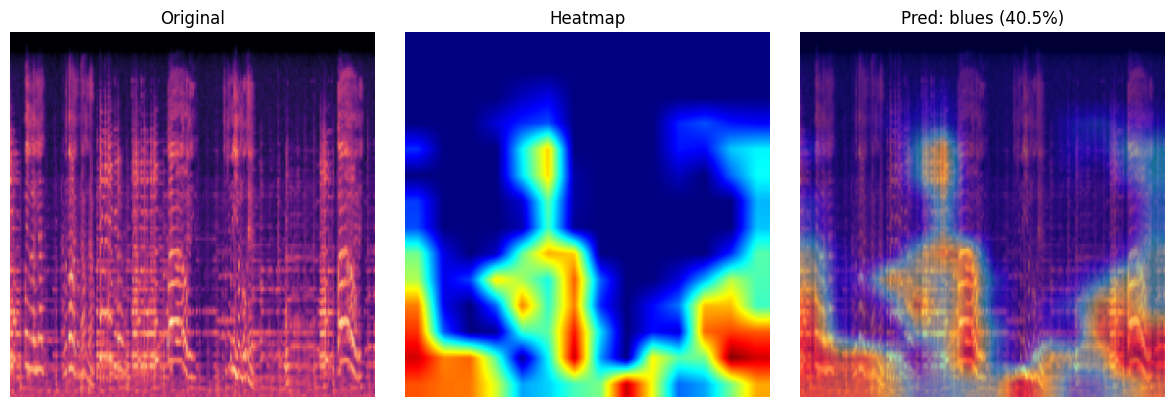

In [11]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
        self._register_hooks()
        self.model.eval()
    def _register_hooks(self):
        def forward_hook(module, inp, out): self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out): self.gradients = grad_out[0].detach()
        self.hooks.append(self.target_layer.register_forward_hook(forward_hook))
        self.hooks.append(self.target_layer.register_full_backward_hook(backward_hook))
    def _remove_hooks(self):
        for h in self.hooks: h.remove()
    def generate_cam(self, inp_tensor, target_class=None):
        out = self.model(inp_tensor)
        probs = F.softmax(out, dim=1)
        if target_class is None:
            target_class = torch.argmax(probs, dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(out); one_hot[0, target_class] = 1
        out.backward(gradient=one_hot, retain_graph=True)
        weights = self.gradients.mean(dim=(2,3))[0]
        cam = torch.zeros(self.activations.shape[2:], device=inp_tensor.device)
        for i, w in enumerate(weights): cam += w * self.activations[0, i]
        cam = F.relu(cam)
        cam = cam / cam.max() if cam.max()>0 else cam
        cam = cam.cpu().numpy()
        return cam, target_class, probs[0, target_class].item()
    def __call__(self, inp_tensor, target_class=None): return self.generate_cam(inp_tensor, target_class)
    def __del__(self): self._remove_hooks()

# Function to visualize GradCAM on a single image
def visualize_gradcam(model, image_path, transform, class_names, device, target_layer=None):
    if target_layer is None:
        # choose last conv block
        target_layer = model.conv4[-1] if isinstance(model, SimpleCNN) else model.layer4[-1]
    gc = GradCAM(model, target_layer)
    img = Image.open(image_path).convert('RGB')
    inp = transform(img).unsqueeze(0).to(device)
    cam, cls, prob = gc(inp)
    # prepare images
    img_np = np.array(img)/255.0
    cam_resized = cv2.resize(cam, (img.width, img.height))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)/255.0
    overlay = np.clip(img_np*0.6 + heatmap*0.4, 0,1)
    # plot
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img_np); axes[0].set_title('Original'); axes[0].axis('off')
    axes[1].imshow(heatmap); axes[1].set_title('Heatmap'); axes[1].axis('off')
    axes[2].imshow(overlay);
    axes[2].set_title(f'Pred: {class_names[cls]} ({prob*100:.1f}%)'); axes[2].axis('off')
    plt.tight_layout()
    gc._remove_hooks()
    return fig

# Example usage
def run_gradcam_example(model_path, data_dir, example_image):
    # Load your trained model
    model = SimpleCNN(len(GENRES)).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    # Transform for input
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    # Visualize
    fig = visualize_gradcam(model, example_image, transform, GENRES, DEVICE)
    fig.savefig('gradcam_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# If run as script
if __name__ == '__main__':
    MODEL_PATH = '/kaggle/working/spectrogram_model.pth'               # path to your saved model
    DATA_DIR = '/kaggle/input/spectograms/for_cnn'    # dataset directory
    EXAMPLE_IMG = os.path.join(DATA_DIR, 'blues', 'blues.00009.png')
    run_gradcam_example(MODEL_PATH, DATA_DIR, EXAMPLE_IMG)

Using device: cuda


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 222MB/s] 
/tmp/ipykernel_31/3186080847.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file

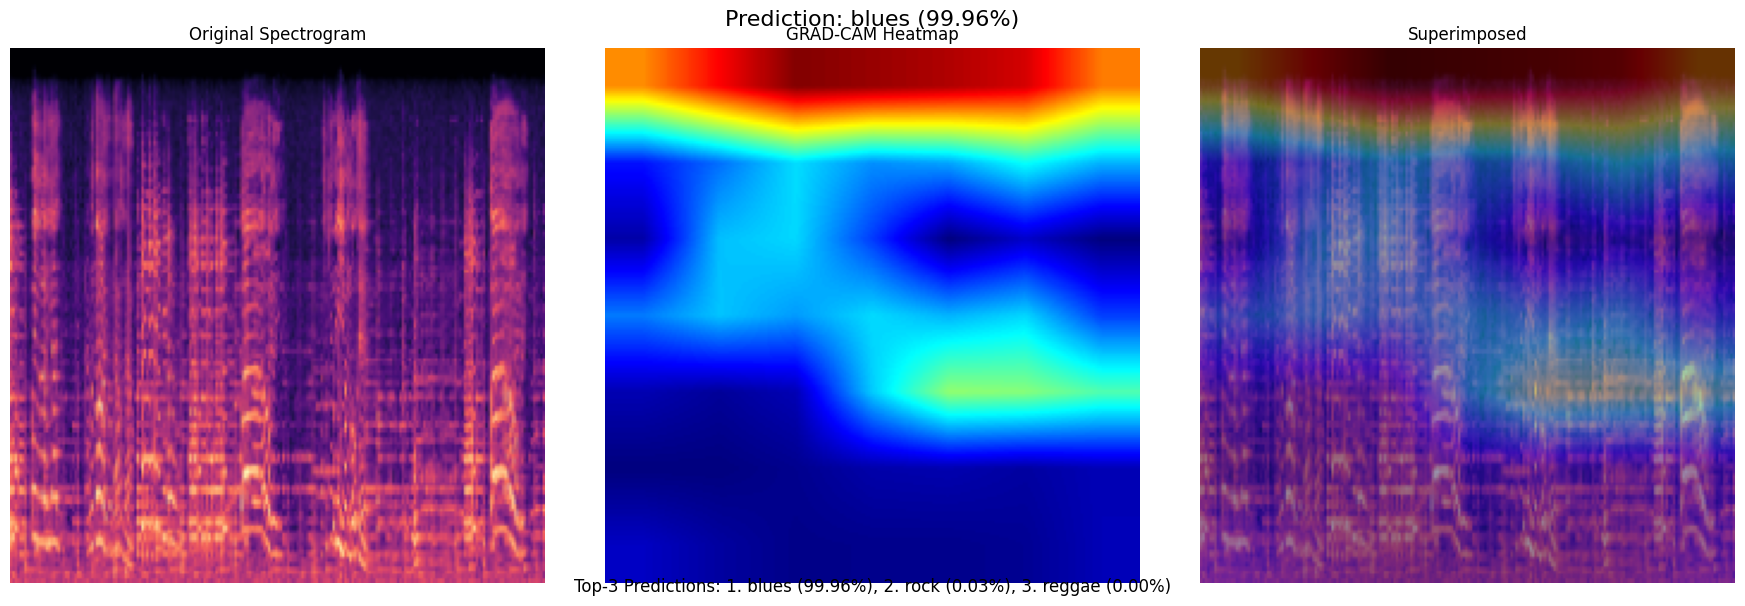


Predictions:
1. blues: 99.96%
2. rock: 0.03%
3. reggae: 0.00%


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Define genres
GENRES = ['rock', 'reggae', 'pop', 'metal', 'jazz', 'hiphop', 'disco', 'country', 'classical', 'blues']

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# VGG19 model with transfer learning (same as in your code)
class VGG19Model(nn.Module):
    def __init__(self, num_classes=10, fine_tune=True):
        super(VGG19Model, self).__init__()
        # Load pretrained VGG19 model
        self.vgg19 = models.vgg19(weights='DEFAULT')
        
        # Freeze or unfreeze the feature extractor based on fine_tune parameter
        if not fine_tune:
            for param in self.vgg19.features.parameters():
                param.requires_grad = False
        
        # Replace the classifier with our own for genre classification
        self.vgg19.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        return self.vgg19(x)

# Function to preprocess an image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    return input_tensor.to(DEVICE), image

# Function to get model prediction
def get_prediction(model, input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)[0]
        
    # Get top 3 predictions
    top_p, top_class = torch.topk(probabilities, 3)
    results = []
    for i in range(3):
        results.append((GENRES[top_class[i].item()], top_p[i].item() * 100))
    
    return results

# GRAD-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.hooks = []
        self.register_hooks()
    
    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        # Register the hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        model_output = self.model(input_tensor)
        
        # If target class is None, use the predicted class
        if target_class is None:
            target_class = torch.argmax(model_output, dim=1).item()
        
        # One-hot encode the target class
        one_hot = torch.zeros_like(model_output)
        one_hot[0, target_class] = 1
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        model_output.backward(gradient=one_hot, retain_graph=True)
        
        # Get weights
        gradients = self.gradients.mean(dim=(2, 3), keepdim=True)
        
        # Generate weighted activations
        weighted_activations = gradients * self.activations
        
        # Global average pooling
        cam = weighted_activations.sum(dim=1, keepdim=True)
        
        # ReLU
        cam = F.relu(cam)
        
        # Normalize
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam_np = cam[0, 0].cpu().numpy()
        cam_np = (cam_np - np.min(cam_np)) / (np.max(cam_np) - np.min(cam_np) + 1e-8)
        
        return cam_np

# Function to visualize GRAD-CAM
def visualize_gradcam(image_path, model_path):
    # Load model
    model = VGG19Model(num_classes=len(GENRES)).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    
    # Get the target layer (last convolutional layer of VGG19)
    target_layer = model.vgg19.features[-1]
    
    # Initialize GRAD-CAM
    grad_cam = GradCAM(model, target_layer)
    
    # Load and preprocess image
    input_tensor, original_image = preprocess_image(image_path)
    
    # Get model prediction
    predictions = get_prediction(model, input_tensor)
    
    # Generate heatmap for top prediction
    top_class_idx = GENRES.index(predictions[0][0])
    heatmap = grad_cam.generate_cam(input_tensor, top_class_idx)
    
    # Convert PIL Image to numpy array for visualization
    original_np = np.array(original_image)
    
    # Apply colormap to heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Superimpose heatmap on original image
    superimposed = cv2.addWeighted(original_np, 0.6, heatmap_colored, 0.4, 0)
    
    # Plot results
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Spectrogram')
    plt.imshow(original_np)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('GRAD-CAM Heatmap')
    plt.imshow(heatmap_colored)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Superimposed')
    plt.imshow(superimposed)
    plt.axis('off')
    
    plt.suptitle(f"Prediction: {predictions[0][0]} ({predictions[0][1]:.2f}%)", fontsize=16)
    
    # Display other predictions
    plt.figtext(0.5, 0.01, 
                f"Top-3 Predictions: 1. {predictions[0][0]} ({predictions[0][1]:.2f}%), " + 
                f"2. {predictions[1][0]} ({predictions[1][1]:.2f}%), " + 
                f"3. {predictions[2][0]} ({predictions[2][1]:.2f}%)",
                ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('grad_cam_result.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return predictions

# Usage
if __name__ == "__main__":
    # Set paths
    MODEL_PATH = '/kaggle/input/vggnet19/pytorch/default/1/VGGNET.pth'  # Path to your saved model
    IMAGE_PATH = '/kaggle/input/spectograms/for_cnn/blues/blues.00009.png'  # Path to your spectrogram image
    
    # Generate and visualize GRAD-CAM
    predictions = visualize_gradcam(IMAGE_PATH, MODEL_PATH)
    
    # Print predictions
    print("\nPredictions:")
    for i, (genre, confidence) in enumerate(predictions):
        print(f"{i+1}. {genre}: {confidence:.2f}%")